# Transfer learning with TF: Fine tuning

Before, feature extraction, now fine tuning

## Creating helper functions 

In previous notebooks, we've created helper functions. Rewrite them is tedious.

In [1]:
#Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## Let's get some data 

This time we are going to see how well we can use the pretrained models within tf.keras.applications and apply them to our problem 

In [2]:
# Let's get the 10 percent of the food vision project 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2021-11-18 18:20:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 172.217.168.176, 172.217.17.16, 142.250.201.80, ...
Conectando con storage.googleapis.com (storage.googleapis.com)|172.217.168.176|:443... conectado.
Petición HTTP enviada, agardando unha resposta... 200 OK
Lonxitude: 168546183 (161M) [application/zip]
Gardando en: «10_food_classes_10_percent.zip.1»

10_food_classes_10_ 100%[===================>] 160,74M  12,7MB/s    in 20s     

2021-11-18 18:21:17 (7,90 MB/s) - gardouse «10_food_classes_10_percent.zip.1» [168546183/168546183]



In [3]:
#Check number of files and directories in dataset 
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
#Create train and test directgory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf 

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
train_data_10_percent.take

<bound method DatasetV2.take of <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>>

In [9]:
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [7.19913387e+00 2.91844821e+00 7.83169317e+00]
   [2.37914467e+01 1.54598179e+01 6.54130793e+00]
   [1.04856934e+02 9.38569336e+01 6.44282227e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [3.00000000e+00 2.14263916e-01 8.87664676e-01]
   [6.51076126e+01 5.51841278e+01 4.26738205e+01]
   [1.05280533e+02 9.42805328e+01 6.48518219e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [8.82673168e+00 4.20930147e+00 1.01023281e+00]
   [9.29338608e+01 8.11328354e+01 6.42756119e+01]
   [1.05505249e+02 9.17093506e+01 6.27245064e+01]]

  ...

  [[1.58000000e+02 1.80000000e+02 1.78000000e+02]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight -forward, but functional API is more flexible with models

In [10]:
#Create base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model 

base_model.trainable = False
#Create inputs into out model 
inputs = tf.keras.layers.Input(shape=(224,224,3),name = "input_layer")
#If using ResNet 50 V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

#Pass the input to the base_model 
x = base_model(inputs)
print(f"Shape after passing inputs through base model :{x.shape}")
#Average poool the outputs of the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="globa_average_pooling_layer")(x)
print(f"Shape after global average pooling 2D: {x.shape}")
#Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

Shape after passing inputs through base model :(None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)


In [11]:
history_0 = model_0.fit(train_data_10_percent,
           epochs=5,
           callbacks = [create_tensorboard_callback("transfer_learning","10_percent_feature_extraction")],
           steps_per_epoch=len(train_data_10_percent),
           validation_data=test_data,
           validation_steps=len(test_data))

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211118-182123


/home/juan/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 90s 4s/step - loss: 1.9256 - accuracy: 0.3760 - val_loss: 1.3742 - val_accuracy: 0.6876
Epoch 2/5
24/24 [==============================] - 83s 4s/step - loss: 1.1607 - accuracy: 0.7373 - val_loss: 0.9440 - val_accuracy: 0.7896
Epoch 3/5
24/24 [==============================] - 82s 4s/step - loss: 0.8592 - accuracy: 0.8000 - val_loss: 0.7618 - val_accuracy: 0.8188
Epoch 4/5
24/24 [==============================] - 85s 4s/step - loss: 0.6954 - accuracy: 0.8453 - val_loss: 0.6706 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 84s 4s/step - loss: 0.5845 - accuracy: 0.8773 - val_loss: 0.6172 - val_accuracy: 0.8388


In [12]:
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

__________________________________________________________________________________________________
block6c_se_reduce (Conv2D)      (None, 1, 1, 48)     55344       block6c_se_reshape[0][0]         
__________________________________________________________________________________________________
block6c_se_expand (Conv2D)      (None, 1, 1, 1152)   56448       block6c_se_reduce[0][0]          
__________________________________________________________________________________________________
block6c_se_excite (Multiply)    (None, None, None, 1 0           block6c_activation[0][0]         
                                                                 block6c_se_expand[0][0]          
__________________________________________________________________________________________________
block6c_project_conv (Conv2D)   (None, None, None, 1 221184      block6c_se_excite[0][0]          
__________________________________________________________________________________________________
block6c_pr

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
globa_average_pooling_layer  (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


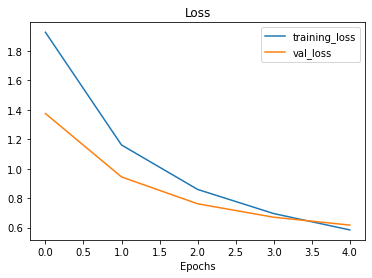

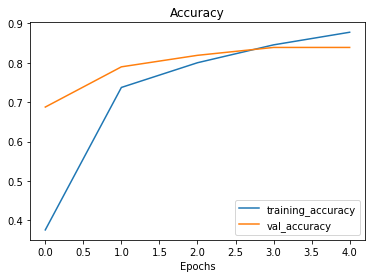

In [15]:
plot_loss_curves(history_0)

## Getting a feature vector from our trained model 

Demonstrate the Global Average Pooling 2D layer... We hae a tensor after our model foes theough "base_model" of shape (NOne,7,7,280). Then it passes through pooling and get (none,1280). We are going to use an example tensor of (1,4,4,3)

In [16]:
input_shape = (1,4,4,3)
#Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor} \n")

#Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor :\n{global_average_pooled_tensor}\n")
#Chech the shape of the tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of pooled tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]] 

2D global average pooled random tensor :
[[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of pooled tensor:(1, 3)


In [17]:
#Replicate the effect of Global Average pooled 2D
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series of transfer learning experiments

Incredible results of transfer learning with ten percent of training data, but only with 1 percent?:

* 1.`model_1`Use feature extraction transfer learning with 1 percent of training data with data augmentation. 
* 2.`model_2`Use feature extraction transfer learning with 10 percent of training data with data augmentation
* 3.`model_3`Use fine tuning transfer learning with 10 percent of training data with data augmentation.
* 4. `model_4`Use fine tuning transfer learning with 100 percent with data augmentation

**Note**: We use always the same test dataset in order to give consistency to the evaluation metrics

In [18]:
#Donwload and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
    
unzip_data("10_food_classes_1_percent.zip")

--2021-11-18 18:28:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 142.250.201.80, 142.250.200.80, 142.250.184.176, ...
Conectando con storage.googleapis.com (storage.googleapis.com)|142.250.201.80|:443... conectado.
Petición HTTP enviada, agardando unha resposta... 200 OK
Lonxitude: 133612354 (127M) [application/zip]
Gardando en: «10_food_classes_1_percent.zip.1»

10_food_classes_1_p 100%[===================>] 127,42M  12,7MB/s    in 10s     

2021-11-18 18:28:39 (12,6 MB/s) - gardouse «10_food_classes_1_percent.zip.1» [133612354/133612354]



In [19]:
#Create train and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [20]:
#Inspect images
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [21]:
#Setup data loaders
IMG_SIZE= (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model 

To add data augmentation, we can use the layers inside: 
* `tf.keras.layers.experimental.preprocessing()`

Using this inside the model can take the advantage of a possible GPU

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255.)
],name = "data_augmentation")

## Visualize data augmentation layer

10_food_classes_1_percent/train/pizza
2924941.jpg


(-0.5, 448.5, 543.5, -0.5)

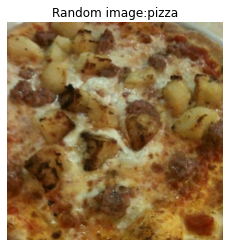

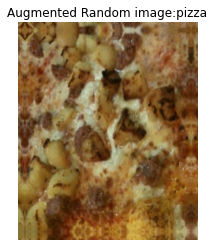

In [23]:
#View a random image and compare
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
print(random_image)
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Random image:{target_class}")
plt.axis("off")

#Now plot the augmented image
augmented_image = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented Random image:{target_class}")
plt.axis("off")

## Model 1: Feature extraction with transfer learning on 1 percent of the data with data augmentation

In [24]:
#Setup the input shape and base_model
input_shape = IMG_SIZE +(3,)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
#Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")
#Add data augmentation as a layer
x=data_augmentation(inputs)
#Give base model after augmented
x=base_model(x,training=False)
#Pull the output features of the model 
x=layers.GlobalAveragePooling2D(name="average_pooling_layer")(x)
#Put a dense layer at the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)
#Make the model 
model_1 = keras.Model(inputs,outputs)
#Compile the model 
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
history_1_percent=model_1.fit(train_data_1_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_1_percent),
                             validation_data=test_data,
                             validation_steps=int(len(test_data)/4),
                             callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                         experiment_name = "1_percent_data_augmentation")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20211118-182845
Epoch 1/5
3/3 [==============================] - 25s 9s/step - loss: 2.4269 - accuracy: 0.0714 - val_loss: 2.2422 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 18s 8s/step - loss: 2.2061 - accuracy: 0.1286 - val_loss: 2.1123 - val_accuracy: 0.2599
Epoch 3/5
3/3 [==============================] - 17s 8s/step - loss: 1.9673 - accuracy: 0.3429 - val_loss: 2.0139 - val_accuracy: 0.3388
Epoch 4/5
3/3 [==============================] - 18s 8s/step - loss: 1.8125 - accuracy: 0.5000 - val_loss: 1.9168 - val_accuracy: 0.3717
Epoch 5/5
3/3 [==============================] - 19s 9s/step - loss: 1.6834 - accuracy: 0.5714 - val_loss: 1.8306 - val_accuracy: 0.4161


In [25]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
average_pooling_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 64s 800ms/step - loss: 1.8193 - accuracy: 0.4404


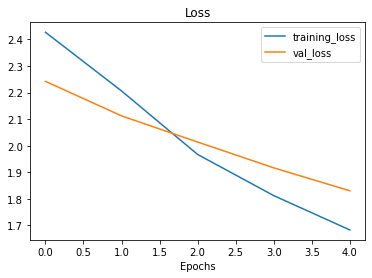

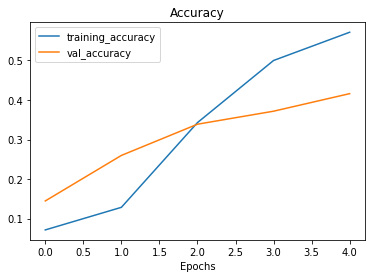

In [27]:
plot_loss_curves(history_1_percent)

## Model 2: feature extraction with 10 % of data and data augmentation

In [28]:
#Get 10% of data
#unzip("10_food_classes_10_percent.zip")
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [29]:
#Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
#Create the data augmentation for model_2
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name="data_augmentation")

In [31]:
#Setup the input_shape
input_shape = IMG_SIZE+(3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Creating the inputs and outputs
inputs = layers.Input(shape = input_shape, name = "input_layer")
#Data augmentation
x = data_augmentation(inputs)
#base_model
x = base_model(x,training=False)
#Pooling 
x = layers.GlobalAveragePooling2D(name = "Pooling_layer")(x)
#Output layer
outputs = layers.Dense(10,activation="softmax",name = "output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [32]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Creating a model checkpoint callback

The model checkpoint callback saves the model, or the weights, at a certain point. Useful to come back and start where it was left.

In [33]:
#Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints/checkpoint.ckpt"
#Create a model checkpoint callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

## Fit model_2 passing model checkpoint callback


In [34]:
#Fit the model saving ckeckpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         epochs=5,
                                         steps_per_epoch=len(train_data_10_percent),
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         callbacks = [create_tensorboard_callback("transfer_learning","10_percent_data_feature_extraction"),
                                         checkpoint_callback])
                

Saving TensorBoard log files to: transfer_learning/10_percent_data_feature_extraction/20211118-183128
Epoch 1/5
24/24 [==============================] - 45s 2s/step - loss: 2.0010 - accuracy: 0.3320 - val_loss: 1.5009 - val_accuracy: 0.6497

Epoch 00001: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 37s 2s/step - loss: 1.3620 - accuracy: 0.6707 - val_loss: 1.0495 - val_accuracy: 0.7944

Epoch 00002: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 40s 2s/step - loss: 1.0522 - accuracy: 0.7520 - val_loss: 0.8528 - val_accuracy: 0.8174

Epoch 00003: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 39s 2s/step - loss: 0.8810 - accuracy: 0.7800 - val_loss: 0.7542 - val_accuracy: 0.8158

Epoch 00004: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 5/5
24/24 [=========================

In [35]:
model_0.evaluate(test_data)

79/79 [==============================] - 64s 802ms/step - loss: 0.6172 - accuracy: 0.8388


[0.6171866059303284, 0.8388000130653381]

In [36]:
model_2.evaluate(test_data)

79/79 [==============================] - 64s 803ms/step - loss: 0.6968 - accuracy: 0.8156


[0.6968386769294739, 0.8155999779701233]

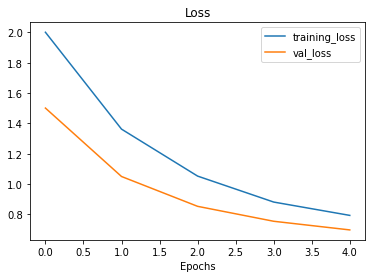

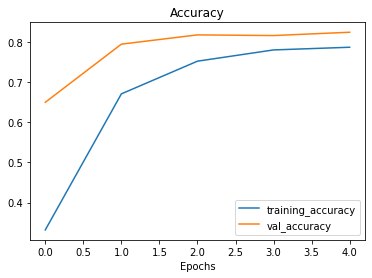

In [37]:
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights

It returns a model to a specific checkpoint.

In [38]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [39]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 66s 829ms/step - loss: 0.6968 - accuracy: 0.8156


## Fine tuning on 10 % of the data

**NOTE**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [40]:
model_2.layers

In [41]:
#Are these layers trainable
for layer in model_2.layers:
    print(layer,layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9fde737890> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9fa0774fd0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9fa3cdaa10> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9fde737850> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9fde72e650> True


In [42]:
for layer in model_2.layers[2].layers:
    print(layer.name,layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [43]:
#How many trainable variables are there in the base_model 
print(len(model_2.layers[2].trainable_variables))

0


In [44]:
# To begin fine tuning, let's start by setting the last ten layers of our base model.trainable = True
base_model.trainable = True
# Freeze all layers except for last ten
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
#Recompile the model every time you make a change
model_2.compile(loss = "categorical_crossentropy",
               optimizer= tf.keras.optimizers.Adam(learning_rate=10e-4),#FINE TUNING , #ULMFit paper
               metrics=["accuracy"])

In [45]:
len(model_2.trainable_variables)

12

In [46]:
#Fine tune for another 5 epochs
fine_tune_epochs = 5 + initial_epochs
#Refit the model
history_fine_10_percent = model_2.fit(train_data_10_percent,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_10_percent_data_aug.epoch[-1],
                                     callbacks=[create_tensorboard_callback("transfer_learning","fine_tuning_1")])

Saving TensorBoard log files to: transfer_learning/fine_tuning_1/20211118-183801
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.7092 - accuracy: 0.7867 - val_loss: 0.4583 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 38s 2s/step - loss: 0.3951 - accuracy: 0.8853 - val_loss: 0.5416 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 39s 2s/step - loss: 0.2759 - accuracy: 0.9000 - val_loss: 0.5548 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 40s 2s/step - loss: 0.1978 - accuracy: 0.9347 - val_loss: 0.5595 - val_accuracy: 0.8322
Epoch 9/10
24/24 [==============================] - 38s 2s/step - loss: 0.1277 - accuracy: 0.9693 - val_loss: 0.5868 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 36s 2s/step - loss: 0.1264 - accuracy: 0.9640 - val_loss: 0.6307 - val_accuracy: 0.8191


In [47]:
results_fine_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 64s 802ms/step - loss: 0.5730 - accuracy: 0.8320


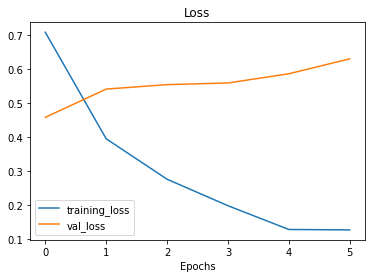

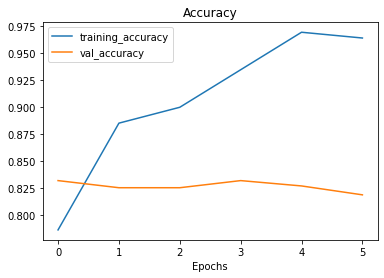

In [48]:
plot_loss_curves(history_fine_10_percent)

 Let's create a function that plot loss curves separating the feature extraction and fine tuning.

In [49]:
def compare_histories(original_history,new_history,initial_epochs=5):
    """Compare two TF history objects"""
    #Get original history measurement
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    #Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    #Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label="Training_accuracy")
    plt.plot(total_val_acc,label="Training_val_accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start_fine_tuning")
    plt.legend(loc="lower right")
    plt.title("Training and validation accuracy")
    
    #Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss,label="Training_loss")
    plt.plot(total_val_loss,label="Training_val_loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start_fine_tuning")
    plt.legend(loc="upper right")
    plt.title("Training and validation loss")
    

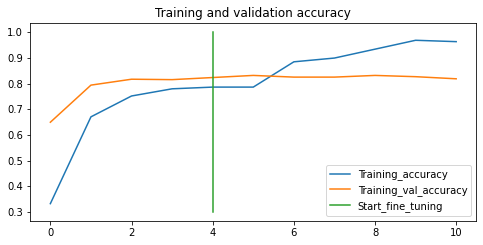

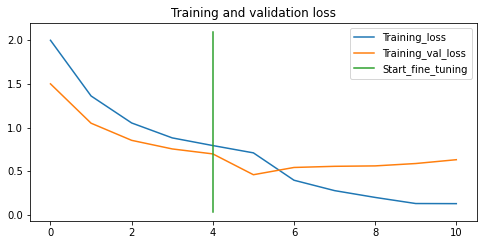

In [50]:
compare_histories(history_10_percent_data_aug,history_fine_10_percent,5)

## Model-4 Fine tuning an exiting model on all the data

In [51]:
#Download and unzip the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-11-18 18:43:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 142.250.200.144, 142.250.184.176, 142.250.200.80, ...
Conectando con storage.googleapis.com (storage.googleapis.com)|142.250.200.144|:443... conectado.
Petición HTTP enviada, agardando unha resposta... 200 OK
Lonxitude: 519183241 (495M) [application/zip]
Gardando en: «10_food_classes_all_data.zip.3»

10_food_classes_all 100%[===================>] 495,13M  14,1MB/s    in 38s     

2021-11-18 18:43:44 (12,9 MB/s) - gardouse «10_food_classes_all_data.zip.3» [519183241/519183241]



In [52]:
#Setup training and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [53]:
#How many images ?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [54]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset is the same we've been using in previous experiments. Let's verify this 

In [55]:
#Evaluate model_2 (fine_tune on 10% of data) on this "new" test_data
model_2.evaluate(test_data)

79/79 [==============================] - 64s 804ms/step - loss: 0.5730 - accuracy: 0.8320


[0.5730350017547607, 0.8320000171661377]

To train a fine tuning model  we need to revert model_2 back to its feature extraction weights, so we can fine tune from the same stage the previous model was fine tuned

In [56]:
model_2.load_weights(checkpoint_path)

In [57]:
#Evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 63s 799ms/step - loss: 0.6968 - accuracy: 0.8156


[0.6968386769294739, 0.8155999779701233]

In [58]:
#Check which layers are tunable
for layer_number,layer in enumerate(model_2.layers):
    print(layer_number,layer,layer.trainable)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9fde737890> True
1 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9fa0774fd0> True
2 <tensorflow.python.keras.engine.functional.Functional object at 0x7f9fa3cdaa10> True
3 <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9fde737850> True
4 <tensorflow.python.keras.layers.core.Dense object at 0x7f9fde72e650> True


In [59]:
#Drill into the base model to check trainability 
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [60]:
# Compile
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=10e-4),
               metrics=["accuracy"])

In [61]:
#Continue to train and fine tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          steps_per_epoch=len(train_data_10_classes_full),
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          initial_epoch=history_10_percent_data_aug.epoch[-1],
                                          callbacks=[create_tensorboard_callback("tranfer_learning","model_full_data")])

Saving TensorBoard log files to: tranfer_learning/model_full_data/20211118-184559
Epoch 5/10
235/235 [==============================] - 254s 1s/step - loss: 0.6932 - accuracy: 0.7789 - val_loss: 0.4239 - val_accuracy: 0.8569
Epoch 6/10
235/235 [==============================] - 244s 1s/step - loss: 0.4879 - accuracy: 0.8415 - val_loss: 0.3266 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 236s 1s/step - loss: 0.4085 - accuracy: 0.8635 - val_loss: 0.3116 - val_accuracy: 0.8816
Epoch 8/10
235/235 [==============================] - 240s 1s/step - loss: 0.3218 - accuracy: 0.8935 - val_loss: 0.3699 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 230s 980ms/step - loss: 0.2829 - accuracy: 0.9037 - val_loss: 0.3386 - val_accuracy: 0.8750
Epoch 10/10
235/235 [==============================] - 234s 994ms/step - loss: 0.2503 - accuracy: 0.9176 - val_loss: 0.4190 - val_accuracy: 0.8684


In [62]:
results_fine_tune_full = model_2.evaluate(test_data)

79/79 [==============================] - 64s 808ms/step - loss: 0.3619 - accuracy: 0.8868


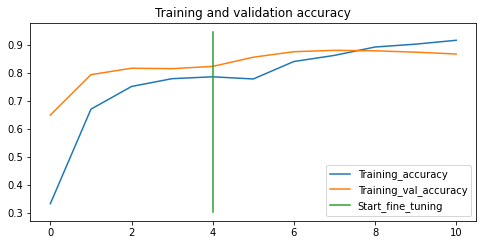

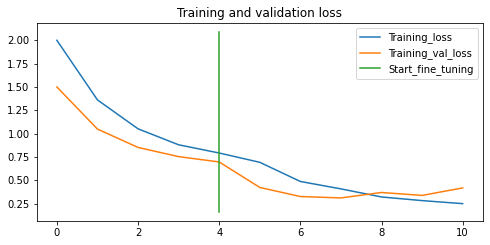

In [63]:
compare_histories(history_10_percent_data_aug,history_fine_10_classes_full)

## Homework

In [65]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode="categorical",
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "categorical",
                                                               image_size= IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [69]:
#Data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name="data_augmentation")

#Setup the input_shape
input_shape = IMG_SIZE+(3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Creating the inputs and outputs
inputs = layers.Input(shape = input_shape, name = "input_layer")
#Data augmentation
x = data_augmentation(inputs)
#base_model
x = base_model(x,training=False)
#Pooling 
x = layers.GlobalAveragePooling2D(name = "Pooling_layer")(x)
#Output layer
outputs = layers.Dense(10,activation="softmax",name = "output_layer")(x)
model_homework = tf.keras.Model(inputs,outputs)

model_homework.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [71]:
initial_epochs = 10

history_homework = model_homework.fit(train_data_10_percent,
          epochs=initial_epochs,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=int(0.25*len(test_data)),
          callbacks=checkpoint_callback)

Epoch 1/10
24/24 [==============================] - 42s 2s/step - loss: 1.8515 - accuracy: 0.3987 - val_loss: 1.3853 - val_accuracy: 0.6776

Epoch 00001: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 2/10
24/24 [==============================] - 38s 2s/step - loss: 1.3107 - accuracy: 0.6613 - val_loss: 1.0220 - val_accuracy: 0.7697

Epoch 00002: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 3/10
24/24 [==============================] - 37s 2s/step - loss: 1.0269 - accuracy: 0.7453 - val_loss: 0.8568 - val_accuracy: 0.7993

Epoch 00003: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 4/10
24/24 [==============================] - 37s 2s/step - loss: 0.9060 - accuracy: 0.7613 - val_loss: 0.7594 - val_accuracy: 0.8125

Epoch 00004: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 5/10
24/24 [==============================] - 37s 2s/step - loss: 0.7824 - accuracy: 0.8040 - val_loss: 0.6888 - val_accuracy: 0.8322


In [74]:
# To begin fine tuning, let's start by setting the last ten layers of our base model.trainable = True
base_model.trainable = True
# Freeze all layers except for last ten
for layer in base_model.layers[:-20]:
    layer.trainable = False
    
#Load in saved model weights and evaluate model
model_homework.load_weights(checkpoint_path)
##
total_epochs = initial_epochs + 10

history_homework_2 = model_homework.fit(train_data_10_percent,
          epochs=total_epochs,
          initial_epoch = history_homework.epoch[-1],
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=int(0.25*len(test_data)),
          callbacks=checkpoint_callback)

Epoch 10/20
24/24 [==============================] - 37s 2s/step - loss: 0.5407 - accuracy: 0.8640 - val_loss: 0.5413 - val_accuracy: 0.8520

Epoch 00010: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 11/20
24/24 [==============================] - 38s 2s/step - loss: 0.5151 - accuracy: 0.8560 - val_loss: 0.5474 - val_accuracy: 0.8355

Epoch 00011: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 12/20
24/24 [==============================] - 38s 2s/step - loss: 0.4779 - accuracy: 0.8733 - val_loss: 0.5124 - val_accuracy: 0.8553

Epoch 00012: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 13/20
24/24 [==============================] - 38s 2s/step - loss: 0.4626 - accuracy: 0.8867 - val_loss: 0.5544 - val_accuracy: 0.8289

Epoch 00013: saving model to 10_percent_model_checkpoints/checkpoint.ckpt
Epoch 14/20
24/24 [==============================] - 38s 2s/step - loss: 0.4330 - accuracy: 0.8907 - val_loss: 0.5448 - val_accuracy: 0.

In [ ]:
# To begin fine tuning, let's start by setting the last ten layers of our base model.trainable = True
base_model.trainable = True
# Freeze all layers except for last ten
for layer in base_model.layers[:-30]:
    layer.trainable = False
    
#Load in saved model weights and evaluate model
model_homework.load_weights(checkpoint_path)
##
total_epochs = initial_epochs + 10

history_homework_3 = model_homework.fit(train_data_10_percent,
          epochs=total_epochs,
          initial_epoch = history_homework.epoch[-1],
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=int(0.25*len(test_data)),
          callbacks=checkpoint_callback)

In [123]:
def make_prediction(target_set,target_class):
    
    target_dir = "10_food_classes_10_percent/"+str(target_set)+"/"+target_class
    random_image = random.choice(os.listdir(target_dir))
    random_image_path = target_dir + "/" + random_image
    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.title(f"Theoretical:{target_class}")
    plt.axis("off")

    #Now plot the augmented image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted:{train_data_10_percent.class_names[model_homework.predict(tf.expand_dims(tf.image.resize(img,[224,224]),0)).argmax()]}")
    plt.axis("off")

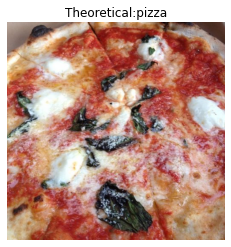

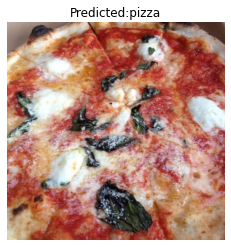

In [124]:
make_prediction("train","pizza")

In [114]:
train_data_10_percent.class_names[model_homework.predict(tf.expand_dims(tf.image.resize(img,[224,224]),0)).argmax()]

'pizza'

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[180.29974 , 180.58546 , 148.9426  ],
         [174.3903  , 174.48853 , 146.19388 ],
         [185.16391 , 184.99426 , 161.50319 ],
         ...,
         [185.19833 , 180.19833 , 142.19833 ],
         [187.03508 , 179.03508 , 142.03508 ],
         [188.48788 , 180.48788 , 143.48788 ]],

        [[177.456   , 180.31313 , 150.49043 ],
         [178.60713 , 181.39285 , 154.13902 ],
         [180.669   , 182.669   , 160.70792 ],
         ...,
         [178.48851 , 172.48851 , 138.34564 ],
         [186.0338  , 179.74619 , 145.69452 ],
         [185.70537 , 176.7768  , 143.56252 ]],

        [[165.99426 , 170.42284 , 143.63712 ],
         [173.76466 , 177.76466 , 154.61034 ],
         [174.40244 , 177.40244 , 157.17029 ],
         ...,
         [179.01018 , 172.8686  , 141.47511 ],
         [179.78572 , 173.57143 , 142.21428 ],
         [179.65367 , 172.57654 , 141.50702 ]],

        ...,

        [[101.70535 ,  67.647964, 